# **Classification of pesticide toxicity to honey bees**
## **About the dataset**

ApisTox dataset is an extensive, consistent and curated collection that focuses on the toxicity of three types of pesticides to honey bees (*Apis mellifera*) combining data from existing sources. The main information provided by this database are toxicity levels, literature related details and possible links to external chemical databases.  

## **Where to get this dataset**

The dataset is freely available in different platforms:

*  [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/995/apistox)
*   [GitHub](https://github.com/j-adamczyk/ApisTox_dataset)

Information about the creation of this database can be found at https://www.nature.com/articles/s41597-024-04232-w

## **Description of the dataset**

### **Overview:**


*   **Number of instances**: 1035
*   **Number of attributes**: 11 features + 2 targets (one for binary classification and one for multiclass classification)
*   **Associated task**: Multiclass classification (Outcome: 0 - non-toxic, 1 - moderately toxic, 2 - highly toxic), Binary classification (0 - non-toxic, 1 - toxic)

### **Variables Description:**

1.   **name** - Chemical name, either according to IUPAC nomenclature or a commonly used trivial name.
2.   **CID** - PubChem Compound ID number.
3.   **CAS** - Chemical Abstracts Service registry number. A globally recognized identifier assigned by CAS, usually written in three blocks of numbers.
4.   **SMILES** - string Molecule structure in SMILES format (text-based representation of a molecule’s structure using specific rules).
5.   **source** - Compound source: ECOTOX, PPDB or BPDB (databases from which the compound information was collected).
6.   **year** - First publication year in literature according to PubChem.
7.   **toxicity_type** - Strongest toxicity type: Contact, Oral or Other.
8.   **herbicide** - Boolean (yes=1/no=0) feature indicating whether the chemical is used as a herbicide.
9.   **fungicide** - Boolean (yes=1/no=0) feature indicating whether the chemical is used as a fungicide.
10.  **insecticide** - Boolean (yes=1/no=0) feature indicating whether the chemical is used as an insecticide.
11.  **other_agrochemical** - Boolean (yes=1/no=0) feature indicating whether the chemical is used in other way as an agrochemical.
12.  **label** - Binary toxicity label (0 = non-toxic, 1 = toxic).
13.  **ppdb_level** - Ternary toxicity level (0 = non-toxic, 1 = moderately toxic, 2 = highly toxic)

### **Target variables:**

In the costruction of this dataset, the classification labels have been created based on the value of $LD_{50}$ (**Lethal Dose 50%**). Two schemes are used:
*  **binary system (`label`)**: based on ***US EPA guidelines***, where an $LD_{50}$ of $11 \mu g / \text{bee}$ or less is labeled as **toxic**
*  **ternary system (`PPDB level`)**: which introduces three tiers **highly toxic** ($\le 1 \mu g / \text{bee}$), **moderately toxic** ($> 1$ and $\le 100 \mu g / \text{bee}$), and **non-toxic** ($> 100 \mu g / \text{bee}$).

Calculating both sets of labels allows the ApisTox database to be flexibly used for either binary or ordinal risk assessment models.

##**Aim of the project**  

Develop a model for multiclass classification able to predict the level of a chemical's toxicity, training it with the data from Apis_tox dataset.


# **Project Pipeline**

# **0. Importing the required libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
import warnings
from pandas import read_csv
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE as SK_RFE, SelectKBest as SKB, chi2
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, make_scorer, roc_auc_score, f1_score, balanced_accuracy_score, log_loss, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc, precision_score, recall_score
from xgboost import XGBClassifier
warnings.filterwarnings("ignore", category=UserWarning)

# **1. Downloading the dataset**

---


In [ ]:
# creation of a pandas DataFrame
csv_file = 'Apis_tox_dataset.csv'
apis_tox = read_csv(csv_file)

# **2. Exploring data with descriptive statistics**

---
## **General information**

In [ ]:
# displaying some general information about the format of the features in the database just created
apis_tox.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   name                1035 non-null   object
 1   CID                 1035 non-null   int64 
 2   CAS                 1035 non-null   object
 3   SMILES              1035 non-null   object
 4   source              1035 non-null   object
 5   year                1035 non-null   int64 
 6   toxicity_type       1035 non-null   object
 7   herbicide           1035 non-null   int64 
 8   fungicide           1035 non-null   int64 
 9   insecticide         1035 non-null   int64 
 10  other_agrochemical  1035 non-null   int64 
 11  label               1035 non-null   int64 
 12  ppdb_level          1035 non-null   int64 
dtypes: int64(8), object(5)
memory usage: 105.2+ KB


In [ ]:
# printing the first part of the database in order to check the correctness of each column
apis_tox.head()

,name,CID,CAS,SMILES,source,year,toxicity_type,herbicide,fungicide,insecticide,other_agrochemical,label,ppdb_level
0,Ethanedioic acid,971,144-62-7,O=C(O)C(=O)O,ECOTOX,1832,Contact,0,0,0,0,0,0
1,Para-cymene,7463,99-87-6,Cc1ccc(C(C)C)cc1,BPDB,1833,Other,0,0,0,1,0,1
2,Kieselguhr,24261,61790-53-2,O=[Si]=O,ECOTOX,1833,Contact,0,0,0,0,0,0
3,Benzoic acid,243,65-85-0,O=C(O)c1ccccc1,ECOTOX,1833,Contact,1,1,1,0,0,1
4,Tetradifon (Ref: ENT 23737),8305,116-29-0,O=S(=O)(c1ccc(Cl)cc1)c1cc(Cl)c(Cl)cc1Cl,PPDB,1836,Oral,0,0,0,1,1,1


We can therefore classify features as:


*   **Binary** (values are only 0/1): herbicide, fungicide, insecticide, other_agrochemical, label

*   **Categorical** (all instances distributed among few values): source (ECOTOX, PPDB, BPDB), toxicity_type (Contact, Oral, Other), ppdb_level (0, 1, 2)

*   **Numerical**: year, CID (despite is a numerical feature, it is an identifier for the molecule, therefore not useful for the analysis).

*   **String / text**: name, CAS, SMILES

In [ ]:
# checking the dimensions of the database
print(apis_tox.shape)

(1035, 13)


In [ ]:
# printing an overview of the values of the features
print(apis_tox.describe())

                CID         year    herbicide    fungicide  insecticide  \
count  1.035000e+03  1035.000000  1035.000000  1035.000000  1035.000000   
mean   6.619015e+06  1969.225121     0.342029     0.190338     0.219324   
std    1.795840e+07    39.418115     0.474619     0.392758     0.413988   
min    2.340000e+02  1832.000000     0.000000     0.000000     0.000000   
25%    1.844950e+04  1958.000000     0.000000     0.000000     0.000000   
50%    8.613200e+04  1977.000000     0.000000     0.000000     0.000000   
75%    5.363382e+06  1995.000000     1.000000     0.000000     0.000000   
max    1.633606e+08  2023.000000     1.000000     1.000000     1.000000   

       other_agrochemical        label   ppdb_level  
count         1035.000000  1035.000000  1035.000000  
mean             0.208696     0.285990     0.994203  
std              0.406573     0.452103     0.580106  
min              0.000000     0.000000     0.000000  
25%              0.000000     0.000000     1.000000  


In [ ]:
# checking the presence of null values
apis_tox.isnull().sum()

,0
name,0
CID,0
CAS,0
SMILES,0
source,0
year,0
toxicity_type,0
herbicide,0
fungicide,0
insecticide,0


From this overview we can see that there aren't missing values.

In [ ]:
# checking the number of uniques value to invstigate how much each feature is informative
apis_tox.nunique()

,0
name,1035
CID,1030
CAS,1035
SMILES,1035
source,3
year,158
toxicity_type,3
herbicide,2
fungicide,2
insecticide,2


As shown from the distribution of unique values, there are four columns that are purely for identification purposes and can be removed, as they are not informative for the purpose of this project.

In [ ]:
apis_tox = apis_tox.drop(columns=['name','CID', 'CAS', 'SMILES'])

## **Class Distribution**

In [ ]:
# calculating the number of values for each class
toxicity_levels = apis_tox.groupby('ppdb_level')
print(toxicity_levels.size())

ppdb_level
0    177
1    687
2    171
dtype: int64


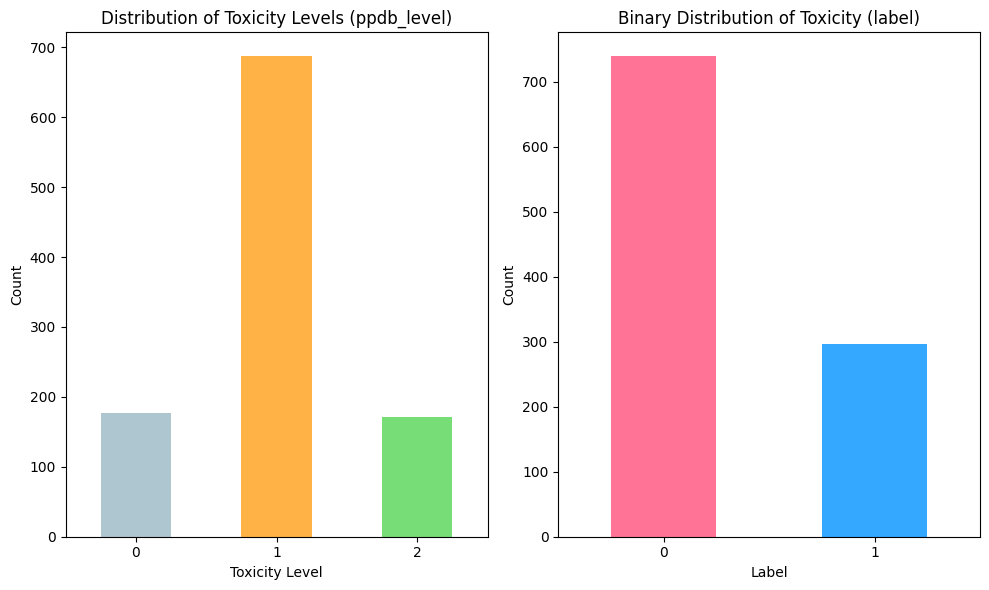

In [ ]:
# representing the class distribution with a bar plot
toxicity_counts = apis_tox.groupby('ppdb_level').size()
label_counts = apis_tox.groupby('label').size()

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
toxicity_counts.plot(kind='bar', color=['#AEC6CF', '#FFB347', '#77DD77'])
plt.title('Distribution of Toxicity Levels (ppdb_level)')
plt.xlabel('Toxicity Level')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
label_counts.plot(kind='bar', color=['#ff7496', '#34a7ff'])
plt.title('Binary Distribution of Toxicity (label)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

This representation clearly shows an imbalance between classes 1 and 2-0 in multiclass classification, and between classes 0 and 1 in binary classification which needs to be taken into account during the analysis.

## **Features Distribution**

## **Histograms**

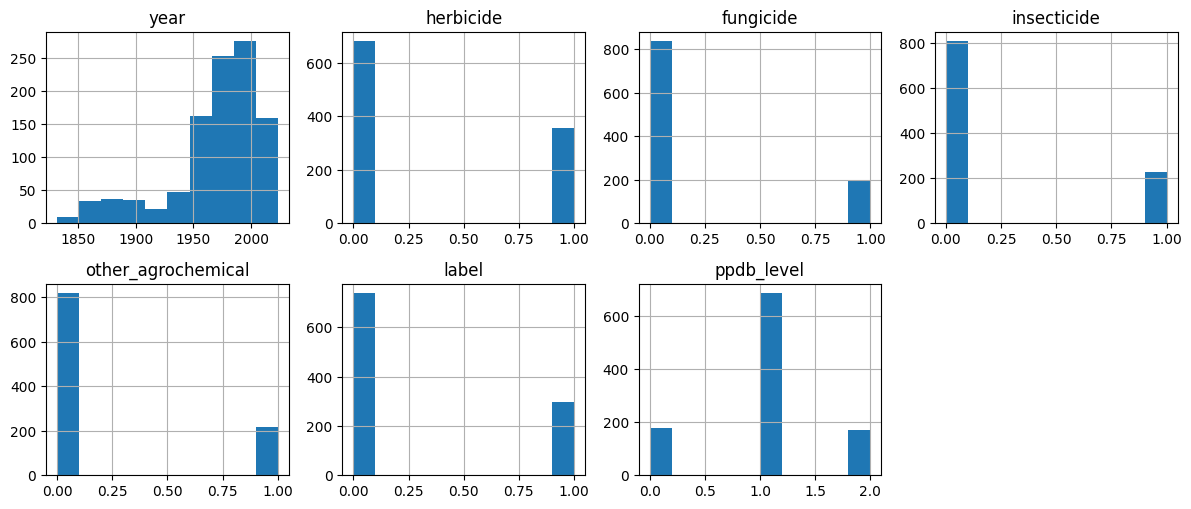

In [ ]:
# Creating a histogram for each colunm in the dataset
apis_tox.hist(figsize=(12, 10), layout=(4, 4))
plt.tight_layout()

In the histograms, the only continuous feature (`year`) demonstrates a left-skewed distribution, with the tail extending towards earlier years. This finding is indicative of an increasing number of publications regarding the toxicity of pesticides in recent years, which may be attributable to an augmented level of interest in this subject within the scientific community. The multi-class target feature (`ppdb_level`) presents a nearly symmetric, bell-shaped histogram, with the bars corresponding to the three classes. In the case of the binary features (`herbicide, fungicide, insecticide, other_agrochemical, label`), the histograms contain only two bars, corresponding to values 0 and 1. It is evident that these distributions are clearly imbalanced, with the bar for 0 substantially higher than the bar for 1. As illustrated by the plot of the class distributions, this column (`label`) denotes a higher abundance of non-toxic examples.

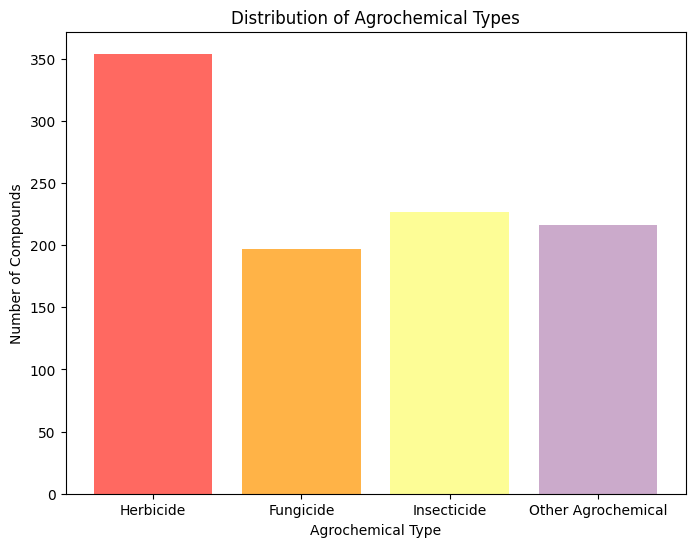

In [ ]:
# checking the distribution of various types of pesticides among the chemicals presents in the dataset
herbicide_count = apis_tox['herbicide'].sum()
fungicide_count = apis_tox['fungicide'].sum()
insecticide_count = apis_tox['insecticide'].sum()
other_agrochemical_count = apis_tox['other_agrochemical'].sum()
labels = ['Herbicide', 'Fungicide', 'Insecticide', 'Other Agrochemical']
counts = [herbicide_count, fungicide_count, insecticide_count, other_agrochemical_count]
plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['#FF6961', '#FFB347', '#FDFD96', '#CBAACB'])
plt.title('Distribution of Agrochemical Types')
plt.xlabel('Agrochemical Type')
plt.ylabel('Number of Compounds')
plt.show()

This bar plot shows that there are more herbicide than other agrochemicals

## **Density plots**

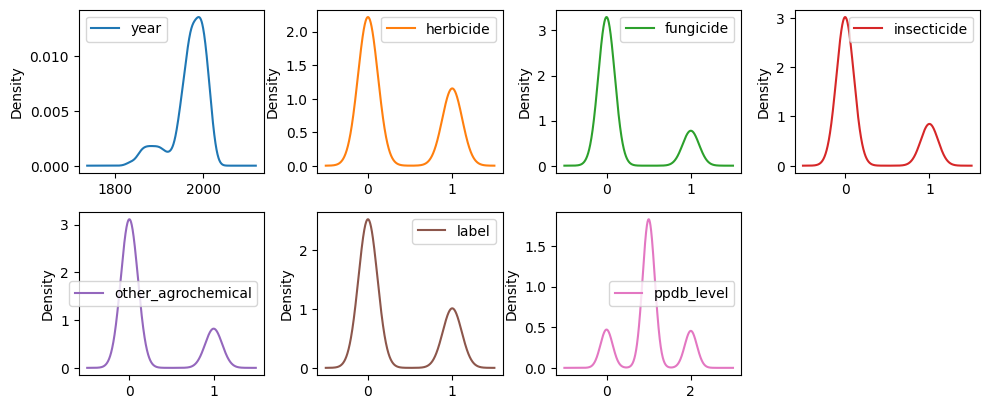

In [ ]:
# displaying the density plot for each numeric feature
apis_tox.plot(kind='density', subplots=True, layout=(4, 4), figsize=(10, 8), sharex=False)
plt.tight_layout()
plt.show()

In accordance with the previous plots, there is a left tail in the continuous column `year`. The binary columns exhibit two peaks corresponding to 0 and 1, and the categorical column `ppdb_level` presents three peaks corresponding to its three categories.

## **Correlation Matrix**

In [ ]:
# calculating the correlations between each pair of columns selecting only numerical features
numeric_apis_tox = apis_tox.select_dtypes(include=['number'])
correlations = numeric_apis_tox.corr()
correlations

,year,herbicide,fungicide,insecticide,other_agrochemical,label,ppdb_level
year,1.000000,0.153857,0.028464,-0.082206,-0.142514,-0.086647,-0.040291
herbicide,0.153857,1.000000,-0.313257,-0.367385,-0.370265,-0.330103,-0.266773
fungicide,0.028464,-0.313257,1.000000,-0.215356,-0.248998,-0.170694,-0.143717
insecticide,-0.082206,-0.367385,-0.215356,1.000000,-0.272203,0.517132,0.436190
other_agrochemical,-0.142514,-0.370265,-0.248998,-0.272203,1.000000,-0.051425,-0.023569
label,-0.086647,-0.330103,-0.170694,0.517132,-0.051425,1.000000,0.636893
ppdb_level,-0.040291,-0.266773,-0.143717,0.436190,-0.023569,0.636893,1.000000


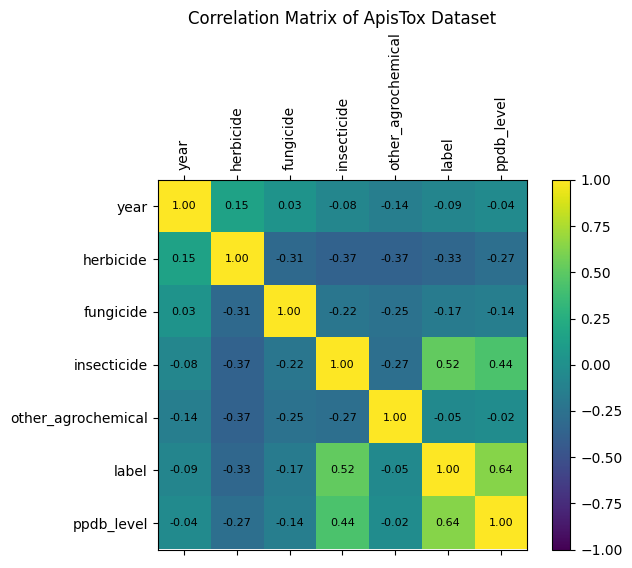


Most Positively Correlated Variable Pairs (excluding self-correlation):
label        ppdb_level     0.636893
ppdb_level   label          0.636893
label        insecticide    0.517132
insecticide  label          0.517132
             ppdb_level     0.436190
ppdb_level   insecticide    0.436190
dtype: float64

Most Negatively Correlated Variable Pairs (excluding self-correlation):
herbicide           label                -0.330103
label               herbicide            -0.330103
insecticide         herbicide            -0.367385
herbicide           insecticide          -0.367385
                    other_agrochemical   -0.370265
other_agrochemical  herbicide            -0.370265
dtype: float64


In [ ]:
# plotting the correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(len(numeric_apis_tox.columns))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(numeric_apis_tox.columns, rotation=90) # Rotate x-axis labels
ax.set_yticklabels(numeric_apis_tox.columns)
plt.title('Correlation Matrix of ApisTox Dataset')

# adding the correlation values inside the cells of the matrix
for i in range(correlations.shape[0]):
    for j in range(correlations.shape[1]):
        text = ax.text(j, i, f"{correlations.iloc[i, j]:.2f}",
                       ha="center", va="center", color="black", fontsize=8)
plt.show()

# calculating the most correlated features
stacked_corr = correlations.stack().sort_values(ascending=False)
most_correlated = stacked_corr[stacked_corr.index.get_level_values(0) != stacked_corr.index.get_level_values(1)]

print("\nMost Positively Correlated Variable Pairs (excluding self-correlation):")
print(most_correlated.head(6))
print("\nMost Negatively Correlated Variable Pairs (excluding self-correlation):")
print(most_correlated.tail(6))

The positive correlation between `ppdb_level` and `label` is consistent, as both variables represent measures of toxicity. For this reason it will be necessary to drop the column `label` for avoiding data leakage. The correlation between `label` and `insecticide` may indicate a slightly higher toxicity of `insecticides` compared to other types of pesticides. Among the negative correlations, the only potentially meaningful one is between `label` and `herbicide`, which could suggest a slightly lower toxicity of `herbicides` relative to other pesticides.

In [ ]:
apis_tox = apis_tox.drop(columns=['label'])

# **3. Splitting the dataset in training and test sets**

---

The dataset is split into training and test sets. This allows the model to be trained on the training set and subsequently evaluated on the test set, providing an assessment of its ability to generalize to unseen data.  

In [ ]:
# Transforming the dataset into array to better manage the train and test split
X = apis_tox.iloc[:,0:7].values
Y = apis_tox.iloc[:,7].astype(int).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=2, stratify=Y)

Since an imbalance between classes was revealed by exploratory data analysis, stratification was used for the division.

# **4. Preprocessing of data**

---

This step involves cleaning and transforming the raw dataset in preparartion for modelling. Each type of feature will be encoded as follows:


*  **Categorical**: *One-hot encoding* --> this involves creating a column for each possible value of the feature, represented by a binary vector indicating whether or not the feature is present.
*  **Numerical**: *Min-max scaling* --> a form of normalisation that allows each value to be expressed within a range of 0–1.
*  **Binary**: already in the correct 0/1 vector format for modelling.



In [ ]:
def classify_columns(dataframe):
  '''
  This function classifies the columns of a dataframe into three types:
  - categorical (if the number of unique values is less than 10)
  - numerical (if the number of unique values is greater than 10)
  - binary (if the number of unique values is 2)
  '''
  column_types = {'categorical_cols' : [],
                  'numerical_cols' : [],
                  'binary_cols' : [],
                  'other_types': []}
  for col in dataframe.columns:
    if dataframe[col].nunique() == 2:
      column_types['binary_cols'].append(col)
    elif dataframe[col].nunique() <= 10:
      column_types['categorical_cols'].append(col)
    elif dataframe[col].nunique() > 10 and pd.api.types.is_integer_dtype(dataframe[col]):
      column_types['numerical_cols'].append(col)
    else:
      column_types['other_types'].append(col)
  return column_types

def preprocessing(train_df):
  '''
  This function creates an object that can properly encode each type of column and be used within a pipeline.
  '''
  col_types = classify_columns(train_df)
  # applying the correct transformation for each column type
  preprocessor = ColumnTransformer(
      transformers=[
          ('cat', OneHotEncoder(handle_unknown='ignore'), col_types['categorical_cols']),
          ('num', MinMaxScaler(), col_types['numerical_cols']),
          ('binary', 'passthrough', col_types['binary_cols'])
      ],
      remainder='drop'
  )
  return preprocessor

In [ ]:
# transforming back the train and test sets in DataFrames
x_train_df = pd.DataFrame(X_train, columns=['source', 'year', 'toxicity_type', 'herbicide', 'fungicide', 'insecticide', 'other_agrochemical'])
x_test_df = pd.DataFrame(X_test, columns=['source', 'year', 'toxicity_type', 'herbicide', 'fungicide', 'insecticide', 'other_agrochemical'])

# applying the preprocessing function to create the object preprocess that will be used inside the pipeline
preprocessor_train = preprocessing(x_train_df)

# **5. Feature selection**

---

This step involves identifying the optimal number of features (𝑘) to retain for the model. By selecting the most relevant features, we can improve model performance, reduce overfitting, and decrease computational complexity.
The process will be executed within a designated **pipeline**, which will enable the preliminary data processing and feature selection for each model.  

This project will utilise two distinct methods for feature selection:
*  **SelectKBest**: utilising the chi-squared test function, it calculates the strength of the relationship between each feature and the target variable by employing the chi-squared statistic. Features with higher scores are considered more relevant and are retained. The chi-squared test is a valuable tool for analysing the dependence between discrete, non-negative values, making it a particularly suitable option for datasets where the majority of features are binary or categorical (as in this case).
*  **Recursive Feature Elimination (RFE)**: with this method an example model is fitted and the features are then ranked based on their importance, with the least important features being removed. This process is repeated until only the desired number of features remain.

Employing two distinct methods enables the selection of the most effective approach and the identification of features with greater reliability.

# **6. Model Training**

---

To evaluate the performances of each model, in this step, a **pipeline** is created using: the object `preprocessor`, one method for feature selection and the model to be evaluated at that time.
This allows the preliminary processing and feature selection for each model, reducing the likelihood of data leakage.

In order to address the imbalance present within the dataset, the parameter **`class_weight= 'balanced'`** has been employed wherever possible. In addition, two models (**Extreme Gradient Boosting Classifier (GBM)** and **Light Gradient Boosting Machine Classifier (LGB)**) have been utilised, as they are particularly well-suited to address such problem.  

## **Model comparison**

In [ ]:
def general_pipeline(preprocessor, selection_method, model):
  '''
  This function creates a pipeline that can be costumised with preprocessing object,
  feature selection method and model chosen by the user
  '''
  return Pipeline(steps=[
      ('preprocessing', preprocessor),
      ('feature_selection', selection_method),
      ('model', model)
  ])

def model_comparison(x_train, y_train, preprocessor, selection_method, models):
  '''
  This function trains a list of models using a pipeline and returns a summary of their performances
  '''
  results = {}
  kfold = StratifiedKFold(n_splits=10, random_state=7, shuffle=True) # Random division of cross validation sets

  for name, model in models:
    pipeline = general_pipeline(preprocessor, selection_method, model)# Creation of the pipeline with the previous function

    cv_acc = cross_val_score(pipeline, x_train, y_train, cv=kfold, scoring='accuracy')# Accuracy
    mean_acc = cv_acc.mean()

    cv_logloss = cross_val_score(pipeline, x_train, y_train, cv=kfold, scoring='neg_log_loss') # Log Loss
    mean_logloss = cv_logloss.mean()

    cv_f1 = cross_val_score(pipeline, x_train, y_train, cv=kfold, scoring='f1_macro') # Macro F1
    mean_f1 = cv_f1.mean()

    cv_prec = cross_val_score(pipeline, x_train, y_train, cv=kfold, scoring=make_scorer(precision_score, average='macro', zero_division=0)) # Precision (macro)
    mean_prec = cv_prec.mean()

    cv_rec = cross_val_score(pipeline, x_train, y_train, cv=kfold, scoring=make_scorer(recall_score, average='macro', zero_division=0))# Recall (macro)
    mean_rec = cv_rec.mean()

    results[name] = {
        "Accuracy": mean_acc,
        "LogLoss": mean_logloss,
        "F1_macro": mean_f1,
        "Precision_macro": mean_prec,
        "Recall_macro": mean_rec,
    }
  summary = pd.DataFrame(results).T
  return summary

In [ ]:
# Performing the model training on the chosen models with two different types of features selection methods

classes, counts = np.unique(Y_train, return_counts=True)# The GBM model needs a ratio between the abundance of the two classes
min_ratio = counts.max() / counts.min()                 # in order to manage the unbalance

#List of models to evaluate
models = [('LR', LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=500)),
          ('KNN', KNeighborsClassifier(n_neighbors=5, metric='hamming')),
          ('CART', DecisionTreeClassifier(class_weight='balanced')),
          ('SVM', SVC(class_weight='balanced', probability=True)),
          ('GBM', XGBClassifier(scale_pos_weight=min_ratio, n_estimators=100, max_depth=3, learning_rate=0.1)),
          ('LGB', lgb.LGBMClassifier(class_weight='balanced', n_estimators=200, learning_rate=0.05, max_depth=-1, num_leaves=31, random_state=42, verbose=-1))]

# Defining two features selection methods
skb = SKB(chi2, k=5)
rfe = SK_RFE(LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=500))

# Applying the function to compare the models
mc_skb = model_comparison(x_train_df, Y_train, preprocessor_train, skb, models)
mc_rfe = model_comparison(x_train_df, Y_train, preprocessor_train, rfe, models)
print("\nModel's performances with SelectKBest:", "\n", mc_skb)
print("\nModel's performances with RFE:", "\n", mc_rfe)


Model's performances with SelectKBest: 
       Accuracy   LogLoss  F1_macro  Precision_macro  Recall_macro
LR    0.418323 -0.911645  0.448268         0.524342      0.584596
KNN   0.646335 -4.107384  0.457628         0.469134      0.512538
CART  0.422712 -1.242660  0.447707         0.507025      0.586517
SVM   0.422712 -0.743453  0.447707         0.507025      0.586517
GBM   0.707081 -0.716796  0.477182         0.438389      0.530940
LGB   0.422712 -0.913660  0.447707         0.507025      0.586517

Model's performances with RFE: 
       Accuracy   LogLoss  F1_macro  Precision_macro  Recall_macro
LR    0.427019 -0.910056  0.458817         0.527029      0.586638
KNN   0.640538 -3.755081  0.464271         0.479282      0.511440
CART  0.425611 -1.244028  0.452099         0.512724      0.592073
SVM   0.425611 -0.734930  0.452099         0.512724      0.592073
GBM   0.707081 -0.716644  0.481895         0.437509      0.540162
LGB   0.425611 -0.914403  0.452099         0.512724      0.592073


From this summary **RFE** appears to offer a marginal benefit in comparison to **SelectKBest** in `F1_macro` and `recall`, the most significant metrics for evaluating a balanced classification across classes. It is for this reason that only RFE will be utilised for the subsequent stage.

With regard to the performances of the models, **GBM** demonstrates superior `accuracy` and `logloss` metrics, indicating its higher general performance. However, it exhibits diminished efficacy in metrics that reflect **class separation**. In contrast, the results obtained by **SVM** and **LR** in the `f1_macro`, `precision` and `recall` metrics are superior, despite exhibiting a substantially reduced level of `accuracy`. **KNN** demonstrates high levels of `accuracy`, but the `logloss` remains far from zero, thus highlighting an instability of the model.
Consequently, the following stage of hyperparameter tuning will utilise: LR, SVM and GBM.

## **Model Tuning**

Tuning of hyperparameters for the best models resulted from the previous comparison.

In [ ]:
def model_tuning(x_train, y_train, preprocessor, selection_method, selected_models, scoring_metrics):
  '''
  This function performs the hyperparameters tuning of a given dictionary of models and parameters grid using a pipeline
  and returns a summary of the performances.
  '''
  tuned_models = {}
  kfold = StratifiedKFold(n_splits=10, random_state=7, shuffle=True)
  best_results_list = []
  metric_cols = [f'mean_test_{key}' for key in scoring_metrics.keys()]

  for name, (model, parameters_grid) in selected_models.items():
    pipeline = general_pipeline(preprocessor, selection_method, model)
    grid = GridSearchCV(estimator=pipeline, param_grid= parameters_grid, scoring=scoring_metrics, refit='recall_macro', cv=kfold, n_jobs=-1) # tests multiple combinations of hyperparameters through cross-validation to find the best model configuration that maximizes performance
    grid.fit(x_train, y_train)
    tuned_models[name] = grid.best_estimator_ # Selects the best model configuration for the current run
    results_df = pd.DataFrame(grid.cv_results_) # converts the metrics calculated in a dataframe
    best_row = results_df.iloc[grid.best_index_]
    model_performance = {'Model': name}
    model_performance.update({col: best_row[col] for col in metric_cols})
    best_results_list.append(model_performance) # filtered results are stored in this list for each model

  results = pd.DataFrame(best_results_list) # displaying in a legible way the results
  results = results.set_index('Model')
  return results, tuned_models

In [ ]:
# Creating a dictionary with the selected models and corresponding parameters
selected_models = { 'SVM': (SVC(class_weight='balanced', probability=True),
                  {
                      'model__C': [1, 5, 10],
                      'model__kernel': ['rbf'],
                      'model__gamma': ['scale', 0.1]
                  }),
                    'GBM': (XGBClassifier(scale_pos_weight=min_ratio,eval_metric='logloss',use_label_encoder=False),
                  {
                      'model__n_estimators': [100, 150],
                      'model__max_depth': [4, 6, 8],
                      'model__learning_rate': [0.05, 0.1],
                      'model__colsample_bytree': [0.7, 0.8]
                  }),
                    'LR': (LogisticRegression(class_weight='balanced', max_iter=1000),
                  {
                      'model__C': [0.1, 1, 10],
                      'model__solver': ['lbfgs'],
                      'model__penalty': ['l2']
                  })}

# Dictionary of the metrics to use for the performance evaluation
metrics = { 'accuracy': 'accuracy',
            'neg_log_loss': 'neg_log_loss',
            'f1_macro': make_scorer(f1_score, average='macro', zero_division=0),
            'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
            'recall_macro': make_scorer(recall_score, average='macro', zero_division=0)}

#Application of the tuning function
tuning, tuned_models = model_tuning(x_train_df, Y_train, preprocessor_train, rfe, selected_models, metrics)
print(round(tuning,6))

       mean_test_accuracy  mean_test_neg_log_loss  mean_test_f1_macro  \
Model                                                                   
SVM              0.425611               -0.736408            0.452099   
GBM              0.707081               -0.719452            0.481895   
LR               0.431346               -0.911614            0.457801   

       mean_test_precision_macro  mean_test_recall_macro  
Model                                                     
SVM                     0.512724                0.592073  
GBM                     0.437509                0.540162  
LR                      0.516018                0.594971  


Post-tuning, **GMB** continues to demonstrate superior overall performance. However, given that the primary objective of this project is to develop a model capable of differentiating between imbalanced classes, the final model to be evaluated on the test set will be **LR**.

# **7. Performance evaluation**

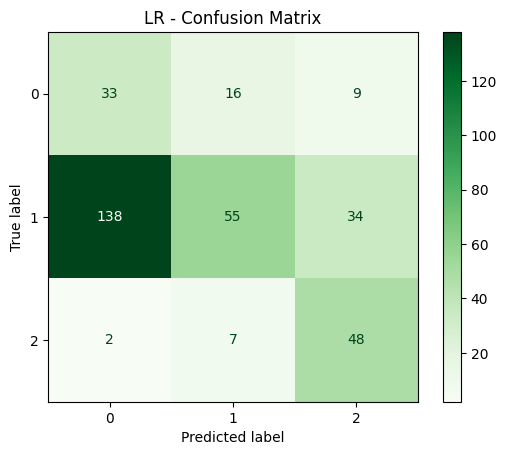

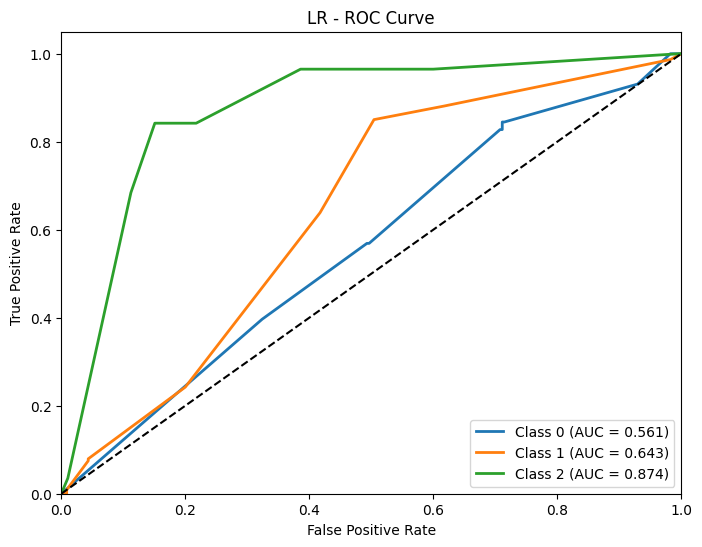

LogLoss: 0.931
F1_macro: 0.432
Precision_macro: 0.474
Recall_macro: 0.551
ROC_AUC: 0.693
Confusion Matrix:
[[ 33  16   9]
 [138  55  34]
 [  2   7  48]]
Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.57      0.29        58
           1       0.71      0.24      0.36       227
           2       0.53      0.84      0.65        57

    accuracy                           0.40       342
   macro avg       0.47      0.55      0.43       342
weighted avg       0.59      0.40      0.40       342



In [ ]:
def evaluate_model(final_model, X_test, y_test, title_prefix="Model"):
  '''
  This function is designed to evaluate the performance of a given model on a test set and returns
  the plot of ROC curve and confusion matrix with a summary of the model's performances.
  '''
  y_pred = final_model.predict(X_test)
  y_test_int = y_test.astype(int)
  y_pred_int = y_pred.astype(int)
  y_prob = final_model.predict_proba(X_test) if hasattr(final_model, "predict_proba") else None

# Calculating the performances of the model on unseen test data
  results = {}
  results['LogLoss'] = log_loss(y_test_int, y_prob, labels=np.unique(y_test_int)) if y_prob is not None else None
  results['F1_macro'] = f1_score(y_test_int, y_pred_int, average='macro', zero_division=0)
  results['Precision_macro'] = precision_score(y_test_int, y_pred_int, average='macro', zero_division=0)
  results['Recall_macro'] = recall_score(y_test_int, y_pred_int, average='macro', zero_division=0)

  try:
    if len(np.unique(y_test_int)) > 2:
      results['ROC_AUC'] = roc_auc_score(y_test_int, y_prob, multi_class='ovr', average='macro')
    else:
      results['ROC_AUC'] = roc_auc_score(y_test_int, y_prob[:, 1])
  except ValueError:
      results['ROC_AUC'] = None

  results['Confusion_Matrix'] = confusion_matrix(y_test_int, y_pred_int)
  results['Classification_Report'] = classification_report(y_test_int, y_pred_int, zero_division=0)

# Displaying the confusion matrix
  cm_display = ConfusionMatrixDisplay.from_predictions(y_test_int, y_pred_int, cmap=plt.cm.Greens)
  plt.title(f"{title_prefix} - Confusion Matrix")
  plt.show()

# Plot of the ROC curve
  if len(np.unique(y_test_int)) > 2:
      # For multiclass classification
      Y_test_bin = label_binarize(y_test_int, classes=np.unique(y_test_int))
      plt.figure(figsize=(8,6))
      for i in range(Y_test_bin.shape[1]):
          fpr, tpr, _ = roc_curve(Y_test_bin[:, i], y_prob[:, i])
          roc_auc_val = auc(fpr, tpr)
          plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc_val:.3f})')
  else:
      # For binary classification
      fpr, tpr, _ = roc_curve(y_test_int, y_prob[:, 1])
      roc_auc_val = auc(fpr, tpr)
      plt.figure(figsize=(8,6))
      plt.plot(fpr, tpr, lw=2, label=f'ROC AUC = {roc_auc_val:.3f}')

  plt.plot([0,1], [0,1], color='black', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f"{title_prefix} - ROC Curve")
  plt.legend(loc='lower right')
  plt.show()

  return results

#Application on the function on the model chosen as the best after the hyperparameters tuning
final_model = tuned_models['LR']
final_model.fit(x_train_df, Y_train)

metrics_results = evaluate_model(final_model, x_test_df, Y_test, title_prefix="LR")

# Displaying the principal results
for k, v in metrics_results.items():
    if k not in ['Confusion_Matrix', 'Classification_Report']:
        print(f"{k}: {v:.3f}" if isinstance(v, float) else f"{k}: {v}")

print("Confusion Matrix:")
print(metrics_results['Confusion_Matrix'])
print("Classification Report:")
print(metrics_results['Classification_Report'])

Based on these results, the model demonstrates some ability to distinguish among the three classes, but it also exhibits a substantial number of misclassifications. In particular, for class 1, incorrect predictions exceed the correct ones. Therefore, this model cannot be considered reliable for accurately classifying the toxicity level of pesticides to honey bees.

# **Binary classification**

---

As stated in the dataset description, apis_tox has been developed for both multiclass and binary classification. Following the poor results obtained from multiclass classification, we will try to repeat the pipeline used to build a binary classification model using the **`label`** column, which was initially discarded, as the **target**.

In [ ]:
# Reloading the entire dataset that has been modified during the analysis
binary_apis_tox = pd.read_csv('Apis_tox_dataset.csv')
# Dropping the notinformative columns and the multiclass target column
binary_apis_tox = binary_apis_tox.drop(columns=['name','CID', 'CAS', 'SMILES', 'ppdb_level'])
binary_apis_tox.head()

,source,year,toxicity_type,herbicide,fungicide,insecticide,other_agrochemical,label
0,ECOTOX,1832,Contact,0,0,0,0,0
1,BPDB,1833,Other,0,0,0,1,0
2,ECOTOX,1833,Contact,0,0,0,0,0
3,ECOTOX,1833,Contact,1,1,1,0,0
4,PPDB,1836,Oral,0,0,0,1,1


## **Dataset split**


In [ ]:
array = binary_apis_tox.values
W = array[:,0:7]
Z = array[:,7].astype(int)
W_train, W_test, Z_train, Z_test = train_test_split(W, Z, test_size=0.33, random_state=2, stratify=Z)
w_train_df = pd.DataFrame(W_train, columns=['source', 'year', 'toxicity_type', 'herbicide', 'fungicide', 'insecticide', 'other_agrochemical'])
w_test_df = pd.DataFrame(W_test, columns=['source', 'year', 'toxicity_type', 'herbicide', 'fungicide', 'insecticide', 'other_agrochemical'])

## **Data preprocessing**

In [ ]:
# Reutilizing the function previousy created to generate a preprocessor object
binary_preprocessor = preprocessing(w_train_df)

## **Model training**

In [ ]:
# Performing the model comparison
bin_mc_skb = model_comparison(w_train_df, Z_train, binary_preprocessor, skb, models)
bin_mc_rfe = model_comparison(w_train_df, Z_train, binary_preprocessor, rfe, models)
print("\nModel's performances with SelectKBest:", "\n", bin_mc_skb)
print("\nModel's performances with RFE:", "\n", bin_mc_rfe)


Model's performances with SelectKBest: 
       Accuracy   LogLoss  F1_macro  Precision_macro  Recall_macro
LR    0.831242 -0.478922  0.799243         0.795378      0.810833
KNN   0.802236 -2.598301  0.773698         0.779960      0.796343
CART  0.826894 -0.613432  0.796427         0.788284      0.812201
SVM   0.826894 -0.417471  0.796427         0.788284      0.812201
GBM   0.828344 -0.534049  0.798053         0.790350      0.813201
LGB   0.829793 -0.460190  0.800483         0.791672      0.817333

Model's performances with RFE: 
       Accuracy   LogLoss  F1_macro  Precision_macro  Recall_macro
LR    0.831263 -0.480198  0.792528         0.795797      0.795865
KNN   0.806625 -2.766874  0.762078         0.782052      0.766681
CART  0.800849 -0.568518  0.767818         0.764412      0.783518
SVM   0.800849 -0.444122  0.767818         0.764412      0.783518
GBM   0.794990 -0.541564  0.770064         0.763983      0.802027
LGB   0.805197 -0.467187  0.773137         0.769255      0.789649


In this case, it is immediately visible that the overall performance of all the models has been enhanced. It is evident that the most optimal models are those produced by **LGB, LR, GBM**.

With regard to the feature selection techniques, SelectKBest appears to demonstrate higher performance in almost all metrics. Therefore, it will be selected for the next step.

In [ ]:
selected_bin_models = {
    'LR': (
    LogisticRegression(class_weight='balanced', max_iter=1000),
    {
        'model__C': [0.1, 1, 10],
        'model__solver': ['lbfgs'],
        'model__penalty': ['l2']
    }
),
   'GBM': (XGBClassifier(scale_pos_weight=min_ratio,eval_metric='logloss',use_label_encoder=False),
    {
        'model__n_estimators': [100, 150],
        'model__max_depth': [4, 6, 8],
        'model__learning_rate': [0.05, 0.1],
        'model__colsample_bytree': [0.7, 0.8]
    }),
      'LGB': (lgb.LGBMClassifier(class_weight='balanced'),
    {
        'model__n_estimators': [100, 150],
        'model__num_leaves': [31, 50],
        'model__learning_rate': [0.05, 0.1],
        'model__max_depth': [-1, 10],
        'model__subsample': [0.8, 1.0],
        'model__colsample_bytree': [0.8, 1.0]
    })}


b_tuning, b_tuned_models = model_tuning(w_train_df, Z_train, binary_preprocessor, skb, selected_bin_models, metrics)
print(round(b_tuning,6))

       mean_test_accuracy  mean_test_neg_log_loss  mean_test_f1_macro  \
Model                                                                   
LR               0.831242               -0.495865            0.799243   
GBM              0.829772               -0.532269            0.800397   
LGB              0.834099               -0.456057            0.804825   

       mean_test_precision_macro  mean_test_recall_macro  
Model                                                     
LR                      0.795378                0.810833  
GBM                     0.791674                0.817333  
LGB                     0.797380                0.820333  


Subsequent to tuning, **LGM** displays marginally enhanced performance. Therefore, it will be selected for the final evaluation on the test set.

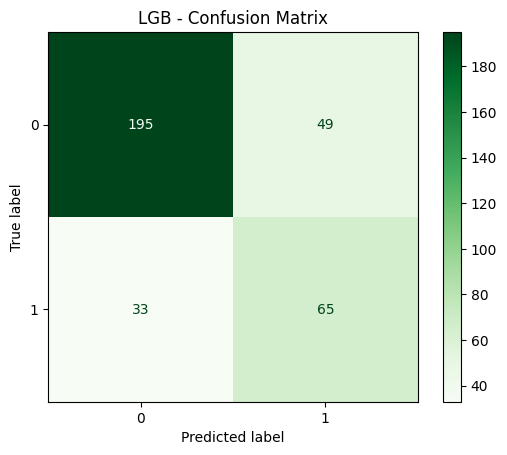

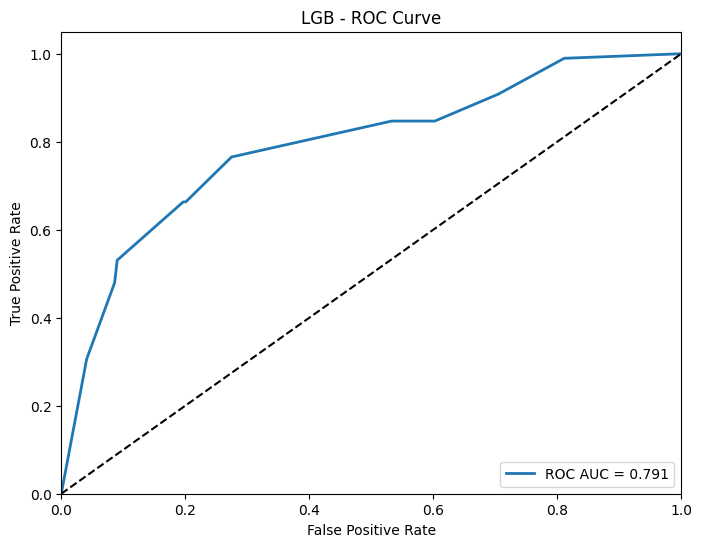

LogLoss: 0.545
F1_macro: 0.720
Precision_macro: 0.713
Recall_macro: 0.731
ROC_AUC: 0.791
Confusion Matrix:
[[195  49]
 [ 33  65]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       244
           1       0.57      0.66      0.61        98

    accuracy                           0.76       342
   macro avg       0.71      0.73      0.72       342
weighted avg       0.77      0.76      0.77       342



In [ ]:
final_bin_model = b_tuned_models['LGB']
final_bin_model.fit(w_train_df, Z_train)

b_metrics_results = evaluate_model(final_bin_model, w_test_df, Z_test, title_prefix="LGB")

for k, v in b_metrics_results.items():
    if k not in ['Confusion_Matrix', 'Classification_Report']:
        print(f"{k}: {v:.3f}" if isinstance(v, float) else f"{k}: {v}")

print("Confusion Matrix:")
print(b_metrics_results['Confusion_Matrix'])
print("Classification Report:")
print(b_metrics_results['Classification_Report'])

In conclusion, the binary classification model has shown considerably higher performance than the multiclass classification model. However, the number of misclassifications remains quite elevated, overall on the prediction of class 1 (less abundant).